In [146]:
import numpy as np
import math
#the world, time emperor
import time

In [171]:
'''
whole functions for 2D HP Absolute calculator
'''

def check_contact_list(current_contact, contacts, contact_threshold):
    contact_check = False
    for i in range(len(contacts)):
        contact_count = 0
        for j in range(len(contacts[i])):
            for k in range(len(current_contact)):
                if(np.array_equal(current_contact[k],contacts[i][j])):
                    contact_count += 1
        if contact_count >= contact_threshold:
            contact_check = True
            break
    return contact_check

def count_HP_2D_contacts_absolute(move_seq, hp_seq):
    '''
    count the contacts within protein (H-H, P-P, H-P) and return the contact tuples
    abs move : clockwise, 0=N, 1=E, 2=S, 3=W, OR None if initial amino acid (which doesnt have any move)
    hp set : 0=P, 1=H
    move length = N-1 ; seq length = N
    '''
    
    move_len = len(move_seq)
    seq_len = len(hp_seq)
    coords = np.zeros((seq_len,2))
    
    #coordinate data structure
    list_coord_dict = []
    
    #movement coordinate translation
    move_N = np.array([0,1])
    move_E = np.array([1,0])
    move_S = np.array([0,-1])
    move_W = np.array([-1,0])
    moves_coor = np.array([move_N, move_E, move_S, move_W])
    
    #interpret the movements to coordinate
    
    coord_dict = {"type":hp_seq[0], "coord":coords[0], "move":None}
    list_coord_dict.append(coord_dict)
    
    for i in range(1, seq_len):
        '''
        if move_seq[i-1] == 0 :
            coord[i] = coord[i-1] + move_N
        elif move_seq[i-1] == 1 :
            coord[i] = coord[i-1] + move_E
        elif move_seq[i-1] == 2 :
            coord[i] = coord[i-1] + move_S
        elif move_seq[i-1] == 3 :
            coord[i] = coord[i-1] + move_W
        '''  
        coords[i] = coords[i-1] + moves_coor[move_seq[i-1]]
        coord_dict = {"type":hp_seq[i], "coord":coords[i], "move":move_seq[i-1]}
        list_coord_dict.append(coord_dict)
    #print(list_coord_dict)
    
    #find contacts (which is adjacent neighbour but not connected (i & k>=i+3))
    contacts = []
    for i in range(1, len(coords)):
        #check each 4 directions:
        for j in range(len(moves_coor)):
            contact = {}
            neighbour_coor = coords[i]+moves_coor[j]
            current_contact = (coords[i], neighbour_coor)
            
            #get the type of contact
            #if()
            
            #check if terminal
            if i == len(coords)-1:
                #check if not i-1
                contact_rule = (not np.array_equal(neighbour_coor, coords[i-1])) and (neighbour_coor.tolist() in coords.tolist())
                #threshold = 2 because the contact list only has at most 2 members
                unique_contact = check_contact_list(current_contact, contacts, 2)
                #if isnt direct neighbor and is not already evaluated
                if contact_rule and (not unique_contact):
                    contacts.append(current_contact)
            else:
                #check if not direct neighbours
                contact_rule = ( (not np.array_equal(neighbour_coor, coords[i+1])) and (not np.array_equal(neighbour_coor, coords[i-1])) ) and (neighbour_coor.tolist() in coords.tolist())
                #if isnt direct neighbor and is not already evaluated
                unique_contact = check_contact_list(current_contact, contacts, 2)
                if contact_rule and (not unique_contact):
                    contacts.append(current_contact)

    '''
    ==>to be continued with contact type identification & set unique contacts
    '''
    #identify contact types
    list_contact_dict = []
    for i in range(len(contacts)):
        contact_dict = {"coord":contacts[i]}
        contact_type = []
        for j in range(len(list_coord_dict)):
            if(np.array_equal(contacts[i][0], list_coord_dict[j]["coord"])):
                contact_type.append(list_coord_dict[j]["type"])
            if(np.array_equal(contacts[i][1], list_coord_dict[j]["coord"])):
                contact_type.append(list_coord_dict[j]["type"])
        contact_dict["type"] = np.array(sorted(contact_type))
        list_contact_dict.append(contact_dict)
        
    #print(list_contact_dict)
                    
    #count each types
    contact_count_dict = {'HH':0, 'HP':0, 'PP':0}
    for contact_dict in list_contact_dict:
        type_HH = np.array([1,1])
        type_HP = np.array([0,1])
        type_PP = np.array([0,0])
        if np.array_equal(type_HH, contact_dict["type"]):
            contact_count_dict['HH'] += 1
        elif np.array_equal(type_HP, contact_dict["type"]):
            contact_count_dict['HP'] += 1
        elif np.array_equal(type_PP, contact_dict["type"]):
            contact_count_dict['PP'] += 1
    
    #print(contact_count_dict)
    
    return contact_count_dict

def transform_real_move(x, ranges, moveset):
    '''
    x : real vector : [1.35324, 0, -34., .....]
    ranges : the range for vector transformation : [-4,-2,0,2,4], length of range = N+1, where N is moveset type 
    moveset : the type of moveset : [N, E, S, W]
    '''
    x_move = np.array([-1]*len(x))
    for i in range(len(x)):
        for j in range(len(ranges)-1):
            if(ranges[j]<x[i] and x[i]<=ranges[j+1]):
                x_move[i] = moveset[j]
    return x_move
    
def protein_fitness(EHH, EHP, EPP, count_HH, count_HP, count_PP):
    fitness = (EHH*count_HH) + (EHP*count_HP) + (EPP*count_PP)
    return fitness

def F_protein(x, hps, ranges, moveset, E_values, return_move_seq=True):
    '''
    Calculate the energy value of protein sequence
    '''
    x_move = transform_real_move(x, ranges, moveset)
    contact_count = count_HP_2D_contacts_absolute(x_move, hps)
    #print(contact_count)
    seq_fitness = protein_fitness(E_values["HH"], E_values["HP"], E_values["PP"], contact_count["HH"], contact_count["HP"], contact_count["PP"])
    #print(seq_fitness)
    if return_move_seq:
        return (seq_fitness, x_move)
    else:
        return seq_fitness
    
    
'''
Differential Evolution Functions
'''
def clip_boundary_psp(vec, domain):
    '''
    custom clipping function for protein folding, added mini padding for low boundary since alpha < moveset (not <=)
    to make sure the vector is within domain,
    if outside, clip them
    '''
    dim = len(domain)
    for i in range(dim):
        if(vec[i]<domain[i][0]):
            vec[i] = domain[i][0] + 1e-1
        elif(vec[i]>domain[i][1]):
            vec[i] = domain[i][1]
    return vec



def diff_evo_psp(F, protein_params, domain, pop_n, mut_weight, CR, itr, stop_threshold, scheme=None, log=False, return_array_per_iter=False):
    '''
    specialized differential evolution for protein folding
    params
        protein_params : dictionary of : 'hp_seq' hp sequence array [0,1,0,1,1...], 'range' range of movement sequence [-4,-2,0,....], 
                        'move_type'moveset type [0,1,2,3], 'e_val' energy contact values {'HH', 'HP', 'PP'}
        other params are the same as normal differential evolution
    '''
    
    #unpack values first to avoid confusion
    hp_seq = protein_params["hp_seq"]
    ranges = protein_params["range"]
    moveset = protein_params["move_type"]
    e_val = protein_params["e_val"]
    
    dim = len(domain)
    population = np.array([np.random.uniform(low=domain[i][0], high=domain[i][1], size=(pop_n,)) for i in range(dim)]).T
    
    it=0
    
    if return_array_per_iter:
        fittest_vectors = np.zeros((itr, dim))
    
    fittest_F = math.inf
    while((it<itr) and (fittest_F>stop_threshold)):
        if log:
            print("iter : ",it)
            fittest_vec = None
        for i in range(pop_n):
            #target vector = i
            tar_vec = population[i]
            
            #mutation
            dist_vec_idx = [j for j in range(pop_n) if j!=i]
            donor_vec = None
            #default scheme, rand/1/bin
            if not scheme:
                #x/y : rand/1 mutation scheme
                dist_vec_idx = np.random.choice(dist_vec_idx, 3, False)
                donor_vec = population[dist_vec_idx[0]] + (mut_weight*(population[dist_vec_idx[1]]-population[dist_vec_idx[2]]))
                # clip out of bound vectors
                donor_vec = clip_boundary_psp(donor_vec, domain)
            else:
                if(scheme[0]=='best'):
                    dist_vec = [population[j] for j in dist_vec_idx]
                    
                    #best_vec_idx = np.argmin(np.array([F(j) for j in dist_vec]))
                    best_vec_idx = np.argmin(np.array([F_protein(x=j, hps=hp_seq, ranges=ranges, moveset=moveset, E_values=e_val, return_move_seq=False) for j in dist_vec]))
                    
                    dist_vec_idx = []
            #crossover
            #binomial crossover
            jr = np.random.randint(dim, size=1)
            crossover_idx = np.random.uniform(0, 1, dim) <= CR
            u_vec = np.zeros(dim)
            for j in range(dim):
                if (crossover_idx[j] == True) or (j == jr):
                    u_vec[j] = donor_vec[j]
                else:
                    u_vec[j] = tar_vec[j]
            #print(tar_vec, donor_vec, crossover_idx, jr, u_vec)
            
            #selection, minimization
            u_fit = F(u_vec, hp_seq, ranges, moveset, e_val, False)
            tar_vec_fit = F(tar_vec, hp_seq, ranges, moveset, e_val, False)
            if u_fit <= tar_vec_fit :
                population[i] = u_vec
            
            #fitness_array = np.array([F(population[j]) for j in range(pop_n)])
            fitness_array = np.array([F_protein(x=population[j], hps=hp_seq, ranges=ranges, moveset=moveset, E_values=e_val, return_move_seq=False) for j in range(pop_n)])

            fittest_vec = population[np.argmin(fitness_array)]
            fittest_F = np.amin(fitness_array)
            
        if log:
            print(fittest_F, fittest_vec)
        
        if return_array_per_iter:
            fittest_vectors[it] = fittest_vec
        
        it+=1
        
    if return_array_per_iter:
        return fittest_vectors, it
    else:
        return fittest_vec, it

In [179]:
'''
Visualization Functions
'''
def move_seq_2_coord(move_seq):
    coords = np.zeros((len(move_seq)+1,2))
    move_coords = np.array([[0,1],[1,0],[0,-1],[-1,0]])
    for i in range(1, len(coords)):
        coords[i] = coords[i-1] + move_coords[move_seq[i-1]]
    return coords

def initial_seq_2_coord(hp_seq):
    coords = np.zeros((len(hp_seq), 2))
    for i in range(1, len(coords)):
        coords[i] = coords[i-1] + np.array([1,0])
    return coords

In [71]:
#test example using HPPHPH
hp_seq = np.array([1,0,0,1,0,1])
ranges = np.array([-4,-2,0,2,4])
moveset = moveset = np.array([0,1,2,3])
e_val = {'HH':-1, 'HP':0, 'PP':0}
protein_params = {'hp_seq':hp_seq, 'range':ranges, 'move_type':moveset,
                  'e_val':e_val}
domain = [[ranges[0], ranges[-1]]]*(len(hp_seq)-1)


start = time.time()
fittest_vec, it = diff_evo_psp(F=F_protein, protein_params=protein_params, domain=domain, pop_n=20, mut_weight=0.8, CR=0.5, itr=100, stop_threshold=-1000, scheme=None)
end = time.time()


print("fittest vector : ",fittest_vec, "at iteration = ", it)
protein_fitness, move_seq= F_protein(fittest_vec, hp_seq, ranges, moveset, e_val, True)
print("Protein Fitness = ",protein_fitness, ", movement sequence = ",move_seq,", runtime = ",end - start)



fittest vector :  [-0.82518389 -3.54127089  4.          4.          0.87998183] at iteration =  100
Protein Fitness =  -2 , movement sequence =  [1 0 3 3 2] , runtime =  20.413153648376465


In [173]:
#test example using HPPHPH, multiple arrays per iteration return
hp_seq = np.array([1,0,0,1,0,1])
ranges = np.array([-4,-2,0,2,4])
moveset = moveset = np.array([0,1,2,3])
e_val = {'HH':-1, 'HP':0, 'PP':0}
protein_params = {'hp_seq':hp_seq, 'range':ranges, 'move_type':moveset,
                  'e_val':e_val}
domain = [[ranges[0], ranges[-1]]]*(len(hp_seq)-1)


start = time.time()
fittest_vecs, it = diff_evo_psp(F=F_protein, protein_params=protein_params, domain=domain, pop_n=20, mut_weight=0.8, CR=0.5, itr=100, stop_threshold=-1000, return_array_per_iter=True)
end = time.time()

print(fittest_vecs)
#print("fittest vector : ",fittest_vec, "at iteration = ", it)
#protein_fitness, move_seq= F_protein(fittest_vec, hp_seq, ranges, moveset, e_val, True)
print("runtime = ",end - start)


[[ 0.3026308   2.11051584 -2.81055972 -3.88135341  3.27412576]
 [ 0.3026308   2.11051584 -2.81055972 -3.88135341  3.27412576]
 [ 0.3026308   2.11051584 -2.81055972 -3.88135341  3.27412576]
 [ 0.3026308   2.11051584 -2.81055972 -3.88135341  3.27412576]
 [ 0.3026308   2.11051584 -3.9        -3.88135341  3.27412576]
 [ 0.3026308   2.11051584 -3.9        -3.88135341  3.27412576]
 [ 0.3026308   2.11051584 -3.9        -3.88135341  3.27412576]
 [ 0.3026308   2.11051584 -3.9        -3.88135341  3.27412576]
 [ 0.3026308   2.11051584 -3.9        -3.88135341  3.27412576]
 [ 0.3026308   2.11051584 -3.04272836  4.          2.57760337]
 [ 0.3026308   2.11051584 -3.04272836  4.          2.57760337]
 [ 0.3026308   2.11051584 -3.04272836  4.          2.57760337]
 [ 0.3026308   2.11051584 -3.04272836  4.          2.57760337]
 [ 0.3026308   2.11051584 -3.04272836  4.          2.57760337]
 [-3.9         2.11051584  1.90108808  2.02395952  1.08408691]
 [-3.48678359 -0.60351747  0.16280572  1.20503064  4.  

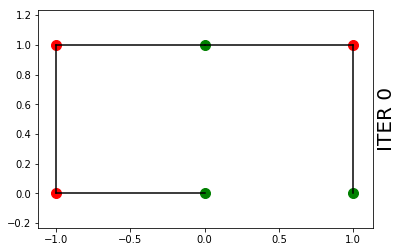

In [152]:
#visualization
import matplotlib.pyplot as plt

coords = move_seq_2_coord(move_seq)
coords = coords.T
x = coords[0]
y = coords[1]

#plt.plot(x,y, 'ro')

f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_label_position("right")
plt.ylabel("ITER 0", fontsize=20)

def connectpoints(x,y,p1,p2):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.plot([x1,x2],[y1,y2],'k-')
    
for i in range(len(x)):
    if hp_seq[i] == 0:
        plt.scatter(x[i], y[i], marker='o', label='first', s=100., c='r')
    else:
        plt.scatter(x[i], y[i], marker='o', label='first', s=100., c='g')

    
for i in range(len(x)-1):
    connectpoints(x,y,i,i+1)
    


plt.axis('equal')
plt.show()

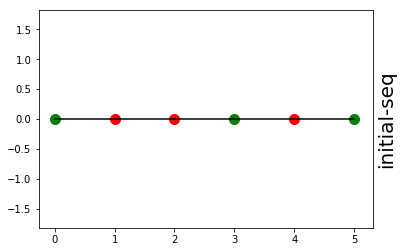

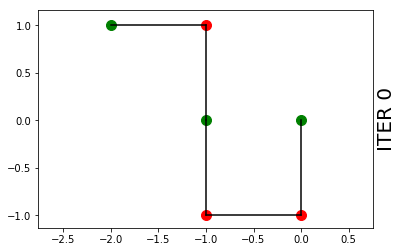

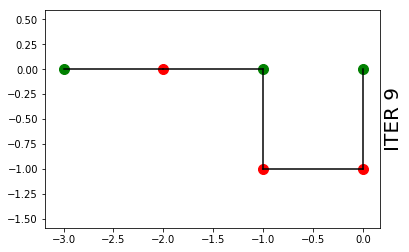

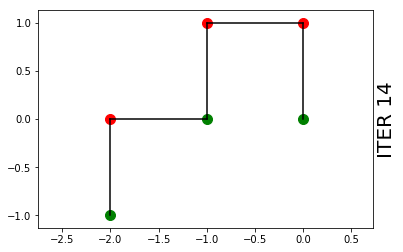

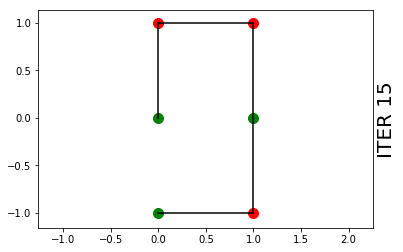

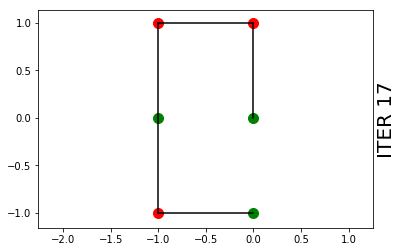

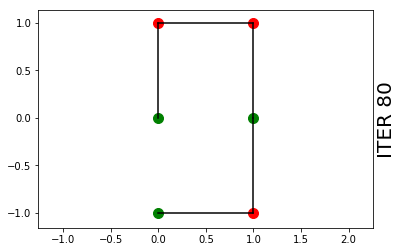

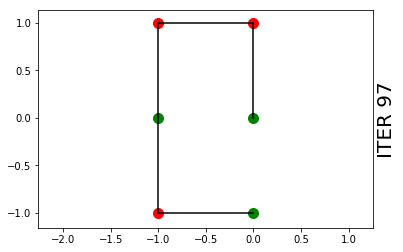

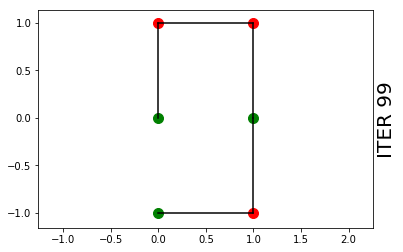

In [186]:
#multiple iteration visualization
def connectpoints(x,y,p1,p2):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.plot([x1,x2],[y1,y2],'k-')

#initial sequence
coords = initial_seq_2_coord(hp_seq)
coords = coords.T
x = coords[0]
y = coords[1]

f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_label_position("right")
plt.ylabel("initial-seq", fontsize=20)

for i in range(len(x)):
    if hp_seq[i] == 0:
        plt.scatter(x[i], y[i], marker='o', label='first', s=100., c='r')
    else:
        plt.scatter(x[i], y[i], marker='o', label='first', s=100., c='g')

for i in range(len(x)-1):
    connectpoints(x,y,i,i+1)

plt.axis('equal')
plt.show()


#next sequences
prev_move_seq= transform_real_move(x=fittest_vecs[0], moveset=moveset, ranges=ranges)

coords = move_seq_2_coord(prev_move_seq)
coords = coords.T
x = coords[0]
y = coords[1]

f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_label_position("right")
plt.ylabel("ITER 0", fontsize=20)

for i in range(len(x)):
    if hp_seq[i] == 0:
        plt.scatter(x[i], y[i], marker='o', label='first', s=100., c='r')
    else:
        plt.scatter(x[i], y[i], marker='o', label='first', s=100., c='g')

for i in range(len(x)-1):
    connectpoints(x,y,i,i+1)

plt.axis('equal')
plt.show()


for itr in range(len(fittest_vecs)) :
    move_seq= transform_real_move(x=fittest_vecs[itr], moveset=moveset, ranges=ranges)
    if(np.array_equal(prev_move_seq, move_seq)):
        #skip index
        continue
    else:
        coords = move_seq_2_coord(move_seq)
        coords = coords.T
        x = coords[0]
        y = coords[1]
        
        f = plt.figure()
        ax = f.add_subplot(111)
        ax.yaxis.set_label_position("right")
        plt.ylabel("ITER 0", fontsize=20)
        
        for i in range(len(x)):
            if hp_seq[i] == 0:
                plt.scatter(x[i], y[i], marker='o', label='first', s=100., c='r')
            else:
                plt.scatter(x[i], y[i], marker='o', label='first', s=100., c='g')

        for i in range(len(x)-1):
            connectpoints(x,y,i,i+1)
            
        plt.ylabel("ITER "+str(itr))
        plt.axis('equal')
        plt.show()
        
    prev_move_seq = move_seq



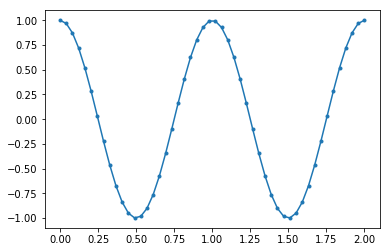

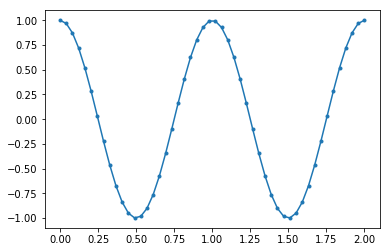

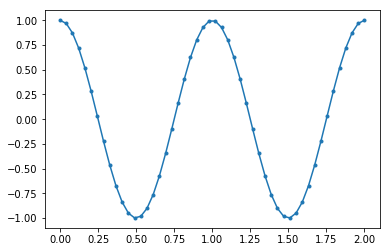

In [70]:
import numpy as np
import matplotlib.pyplot as plt


x1 = np.linspace(0.0, 5.0)
x2 = np.linspace(0.0, 2.0)

y1 = np.cos(2 * np.pi * x1) * np.exp(-x1)
y2 = np.cos(2 * np.pi * x2)

'''
plt.subplot(3, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('A tale of 2 subplots')
plt.ylabel('Damped oscillation')

plt.subplot(3, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('time (s)')
plt.ylabel('Undamped')

plt.subplot(3, 1, 3)
plt.plot(x2, y2, '.-')
plt.xlabel('time (s)')
plt.ylabel('Undamped')
'''


n=3
for i in range(1, n+1):
    #plt.subplot(n, 1, i)
    plt.plot(x2, y2, '.-')
    plt.show()

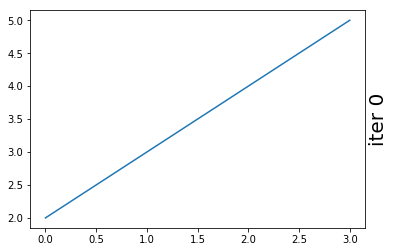

In [133]:
from matplotlib import pyplot as plt


f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_label_position("right")
#ax.yaxis.tick_right()
plt.plot([2,3,4,5])
plt.ylabel("iter 0", fontsize=20)
plt.show()

In [180]:
print(hp_seq)
init_seq = initial_seq_2_coord(hp_seq)
init_seq

[1 0 0 1 0 1]


array([[0., 0.],
       [1., 0.],
       [2., 0.],
       [3., 0.],
       [4., 0.],
       [5., 0.]])